You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

import itertools

%matplotlib inline

In [2]:
df=pd.read_csv('results.csv')

In [3]:
pd.set_option('display.expand_frame_repr', False)
from IPython.display import display
pd.options.display.max_columns=None
df=df.reindex(sorted(df.columns),axis=1)
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
0,17.37,37.65,47.67,59.18,71.40,80.43,8.02,47,W1,Fukuoka,JPN,NaN,8,M,8,39.72,"Yamamoto, Hiroyuki",85.25,8,3.27,NaN
1,32.58,65.83,82.43,99.33,116.37,132.10,16.22,33,F1,Eldoret,KEN,NaN,1,F,1,69.47,"Jeptoo, Rita",138.95,21,5.30,NaN
2,16.62,36.10,45.80,56.45,67.42,76.10,7.75,41,W2,Paarl,RSA,NaN,1,M,1,38.03,"Van Dyk, Ernst F.",80.60,1,3.08,NaN
3,32.57,65.83,82.43,99.33,116.37,132.95,16.20,24,F2,Shoa,ETH,NaN,3,F,3,69.47,"Dibaba, Mare",140.58,27,5.37,NaN
4,17.12,36.58,46.37,57.03,67.83,76.72,8.02,40,W3,Nogata Fukuoka,JPN,NaN,2,M,2,38.60,"Hokinoue, Kota",81.23,2,3.10,NaN


In [4]:
df.dtypes

10k           object
20k           object
25k           object
30k           object
35k           object
40k           object
5k            object
age            int64
bib           object
city          object
country       object
ctz           object
division       int64
gender        object
genderdiv      int64
half          object
name          object
official     float64
overall        int64
pace         float64
state         object
dtype: object

In [5]:
X=df.iloc[:,:7]

In [6]:
df.shape

(31984, 21)

## Features Selection

In [7]:
col=X.columns.values
col

array(['10k', '20k', '25k', '30k', '35k', '40k', '5k'], dtype=object)

## Data Cleaning

In [8]:
col=X.columns.values
for i in col:
    df.drop(df[df[i]=='-'].index,inplace=True)
    df[i]=df[i].astype(float)

In [9]:
df.shape

(31687, 21)

In [10]:
df.dtypes

10k          float64
20k          float64
25k          float64
30k          float64
35k          float64
40k          float64
5k           float64
age            int64
bib           object
city          object
country       object
ctz           object
division       int64
gender        object
genderdiv      int64
half          object
name          object
official     float64
overall        int64
pace         float64
state         object
dtype: object

In [11]:
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
0,17.37,37.65,47.67,59.18,71.40,80.43,8.02,47,W1,Fukuoka,JPN,NaN,8,M,8,39.72,"Yamamoto, Hiroyuki",85.25,8,3.27,NaN
1,32.58,65.83,82.43,99.33,116.37,132.10,16.22,33,F1,Eldoret,KEN,NaN,1,F,1,69.47,"Jeptoo, Rita",138.95,21,5.30,NaN
2,16.62,36.10,45.80,56.45,67.42,76.10,7.75,41,W2,Paarl,RSA,NaN,1,M,1,38.03,"Van Dyk, Ernst F.",80.60,1,3.08,NaN
3,32.57,65.83,82.43,99.33,116.37,132.95,16.20,24,F2,Shoa,ETH,NaN,3,F,3,69.47,"Dibaba, Mare",140.58,27,5.37,NaN
4,17.12,36.58,46.37,57.03,67.83,76.72,8.02,40,W3,Nogata Fukuoka,JPN,NaN,2,M,2,38.60,"Hokinoue, Kota",81.23,2,3.10,NaN


## Shuffle

In [12]:
from sklearn.utils import shuffle
df = shuffle(df)

In [13]:
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
28886,67.98,152.60,197.63,248.03,296.17,345.20,33.73,25,32458,Brighton,USA,NaN,6747,F,13885,161.77,"Bergstein, Jamie A",365.28,31089,13.93,MA
5775,43.23,86.17,108.87,133.50,160.18,187.67,21.77,39,6577,Stittsville,CAN,NaN,2954,M,5534,91.00,"Haggerty, Kevin",199.97,6467,7.63,ON
3914,55.50,112.22,140.67,170.62,202.35,252.53,27.32,33,4437,Minneapolis,USA,NaN,4600,M,13400,118.20,"Elwell, Peter",267.82,23121,10.22,MN
23939,48.87,98.83,124.32,150.97,177.97,205.67,24.10,26,27167,Boston,USA,NaN,2277,F,3221,104.23,"Furman, Danielle S.",217.32,11560,8.30,MA
4613,44.15,93.20,120.52,150.58,182.38,218.58,21.80,27,5248,New York,USA,NaN,3910,M,10333,98.75,"Gennusa, Martin J.",233.17,16143,8.90,NY


## Reset dataframe Index

In [14]:
df=df.reset_index(drop=True)

In [15]:
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
0,67.98,152.60,197.63,248.03,296.17,345.20,33.73,25,32458,Brighton,USA,NaN,6747,F,13885,161.77,"Bergstein, Jamie A",365.28,31089,13.93,MA
1,43.23,86.17,108.87,133.50,160.18,187.67,21.77,39,6577,Stittsville,CAN,NaN,2954,M,5534,91.00,"Haggerty, Kevin",199.97,6467,7.63,ON
2,55.50,112.22,140.67,170.62,202.35,252.53,27.32,33,4437,Minneapolis,USA,NaN,4600,M,13400,118.20,"Elwell, Peter",267.82,23121,10.22,MN
3,48.87,98.83,124.32,150.97,177.97,205.67,24.10,26,27167,Boston,USA,NaN,2277,F,3221,104.23,"Furman, Danielle S.",217.32,11560,8.30,MA
4,44.15,93.20,120.52,150.58,182.38,218.58,21.80,27,5248,New York,USA,NaN,3910,M,10333,98.75,"Gennusa, Martin J.",233.17,16143,8.90,NY


## Deivide dataset to 4 evenly sized subset

In [16]:
rows=df.shape[0]-df.shape[0]%4
df=df.iloc[:rows,:8]
df.head()

,10k,20k,25k,30k,35k,40k,5k,age
0,67.98,152.60,197.63,248.03,296.17,345.20,33.73,25
1,43.23,86.17,108.87,133.50,160.18,187.67,21.77,39
2,55.50,112.22,140.67,170.62,202.35,252.53,27.32,33
3,48.87,98.83,124.32,150.97,177.97,205.67,24.10,26
4,44.15,93.20,120.52,150.58,182.38,218.58,21.80,27


In [17]:
df.shape

(31684, 8)

In [18]:
df=np.split(df,4,axis=0)

In [19]:
df[0]

,10k,20k,25k,30k,35k,40k,5k,age
0,67.98,152.60,197.63,248.03,296.17,345.20,33.73,25
1,43.23,86.17,108.87,133.50,160.18,187.67,21.77,39
2,55.50,112.22,140.67,170.62,202.35,252.53,27.32,33
3,48.87,98.83,124.32,150.97,177.97,205.67,24.10,26
4,44.15,93.20,120.52,150.58,182.38,218.58,21.80,27
5,50.02,102.65,128.98,156.72,185.07,213.23,24.73,41
6,52.47,106.17,135.07,164.85,195.70,227.02,25.90,49
7,47.20,94.75,118.80,143.13,167.58,191.75,23.83,26
8,41.30,83.22,104.00,125.08,146.68,168.57,20.48,38
9,64.07,133.83,174.03,222.98,278.22,325.57,30.68,65


## Features Selection

In [20]:
df[0].iloc[:rows,:7]

,10k,20k,25k,30k,35k,40k,5k
0,67.98,152.60,197.63,248.03,296.17,345.20,33.73
1,43.23,86.17,108.87,133.50,160.18,187.67,21.77
2,55.50,112.22,140.67,170.62,202.35,252.53,27.32
3,48.87,98.83,124.32,150.97,177.97,205.67,24.10
4,44.15,93.20,120.52,150.58,182.38,218.58,21.80
5,50.02,102.65,128.98,156.72,185.07,213.23,24.73
6,52.47,106.17,135.07,164.85,195.70,227.02,25.90
7,47.20,94.75,118.80,143.13,167.58,191.75,23.83
8,41.30,83.22,104.00,125.08,146.68,168.57,20.48
9,64.07,133.83,174.03,222.98,278.22,325.57,30.68


## Create Empty List

In [21]:
features=[]
target=[]

In [22]:
for i in range(0,4):
    features.append(df[i].iloc[:rows,:7])
    target.append(df[i].iloc[:rows,7])

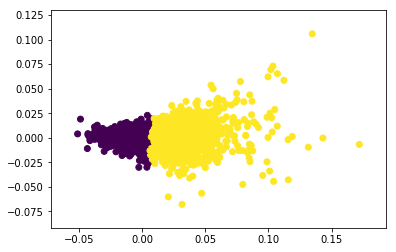

col_0     0     1
row_0            
0      2830  2622
1      1172  1297
0.0016436618594900334


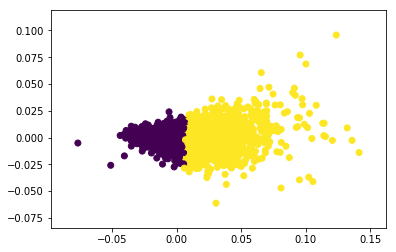

col_0     0     1
row_0            
0      2787  2709
1      1174  1251
0.0002756594753415765


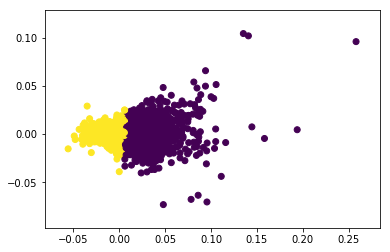

col_0     0     1
row_0            
0      1134  1279
1      2834  2674
0.0013752684445254956


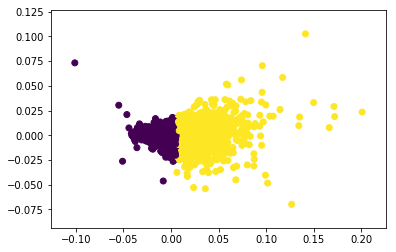

col_0     0     1
row_0            
0      2826  2674
1      1149  1272
0.0010962395805052235


In [23]:
for i in range(0,4):
    X_norm=normalize(features[i])
    X_pca=PCA(2).fit_transform(X_norm)
    y=np.where(target[i]>42,1,0)

    y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
    plt.show()

    table=pd.crosstab(y_pred,y)
    print(table)

    score=metrics.adjusted_rand_score(y,y_pred)
    print(score)

## Adjusted Rand Score

In [24]:
for i in range(0,4):
    X_norm=normalize(features[i])
    X_pca=PCA(2).fit_transform(X_norm)
    y=np.where(target[i]>42,1,0)

    y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_norm)

    #plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
    #plt.show()

    table=pd.crosstab(y_pred,y)
    print(table)

    score=metrics.adjusted_rand_score(y,y_pred)
    print(score)
    print()

col_0     0     1
row_0            
0      2831  2623
1      1171  1296
0.0016436681110468638

col_0     0     1
row_0            
0      2786  2708
1      1175  1252
0.0002756100813960351

col_0     0     1
row_0            
0      1136  1280
1      2832  2673
0.001355813021112174

col_0     0     1
row_0            
0      1150  1275
1      2825  2671
0.0011314741388371936



## Silhouette Coefficient

In [25]:
for n in range(2,3):
    print()
    print("Number of Clusters: ",n)
    for i in range(0,4):
        X_norm=normalize(features[i])
        y=np.where(target[i]>42,1,0)

        model = KMeans(n_clusters=n, random_state=42).fit(X_norm)
        labels=model.labels_
      
        score=metrics.silhouette_score(X_norm, labels, metric='euclidean')
        print(score)
        


Number of Clusters:  2
0.5241659181626328
0.5196334174644056
0.5273983208566015
0.5182503807995255


## Mean-Shift

In [26]:
for i in range(0,4):
    X_norm=normalize(features[i])
    X_pca=PCA(2).fit_transform(X_norm)
    y=np.where(target[i]>42,1,0)

    bw=estimate_bandwidth(X_norm,quantile=0.2)

    mode=MeanShift(bandwidth=bw,bin_seeding=True)
    model.fit(X_norm)
    
    labels=model.labels_
    
    n_clusters=len(np.unique(labels))

    print("Number of Clusters: ",n_clusters)
    
    score=metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print(score)
    print()

Number of Clusters:  2
0.5241659181626328

Number of Clusters:  2
0.5196334174644056

Number of Clusters:  2
0.5273983208566015

Number of Clusters:  2
0.5182503807995255

